In [1]:
import math
import random

import gym
import numpy as np
import torch
import gym_cartpole_swingup
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

In [2]:
%matplotlib inline

## Configuration

In [3]:
# config

# ENV_NAME = "CartPoleSwingUp-v0"
ENV_NAME = "CartPoleSwingUp-v1"
# ENV_NAME = "CartPole-v0"
# ENV_NAME = "CartPole-v1"
# ENV_NAME = "Pendulum-v0"
ENV_COUNT = 16

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Environment setup

In [4]:
envs = [gym.make(ENV_NAME) for _ in range(ENV_COUNT)]

In [5]:
def reset(envs):
    return torch.as_tensor(np.stack([env.reset() for env in envs]), dtype=torch.float32)

In [6]:
def step(envs, actions):
    results = [env.step(action) for env, action in zip(envs, actions)]
    obs, rews, dones, infos = zip(*results)
    return torch.as_tensor(np.stack(obs), dtype=torch.float32), \
        torch.as_tensor(np.stack(rews), dtype=torch.float32), \
        torch.as_tensor(np.stack(dones), dtype=torch.bool), \
        infos

In [7]:
def get_random_actions(envs):
    return torch.as_tensor(np.stack([env.action_space.sample() for env in envs]))

In [8]:
def render(envs):
    for env in envs:
        env.render()

In [9]:
def close(envs):
    for env in envs:
        env.close()

## Model setup

In [10]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)

In [11]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

## Generalized Advantage Estimation (GAE)

In [12]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

## Proximal Policy Optimization Algorithm

**[Arxiv](https://arxiv.org/abs/1707.06347)**

In [13]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

## Training

In [14]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    env = gym.make(ENV_NAME)
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

In [15]:
num_inputs  = envs[0].observation_space.shape[0]
# num_outputs = envs[0].action_space.n
num_outputs = envs[0].action_space.shape[0]

#Hyper params:
hidden_size      = 256
lr               = 3e-4
num_steps        = 20
mini_batch_size  = 5
ppo_epochs       = 4
threshold_reward = 50

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [16]:
max_frames = 15000
frame_idx  = 0
test_rewards = []

Exception ignored in: <function Viewer.__del__ at 0x000001F423FB9F70>
Traceback (most recent call last):
  File "c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\pyglet\window\win32\__init__.py", line 319, in close
    super(Win32Window, self).close()
  File "c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\pyglet\window\__init__.py", line 838, in close
    app.windows.remove(self)
  File "c:\Users\TeamD\.conda\envs\subgame\lib\_weakrefset.py", line 114, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x000001F43A1D44F0; to 'Win32Window' at 0x000001F43DCB11F0>
Exception ignored in: <function Viewer.__del__ at 0x000001F423FB9F70>
Traceback (most recent call last):
  File "c:\Users\TeamD

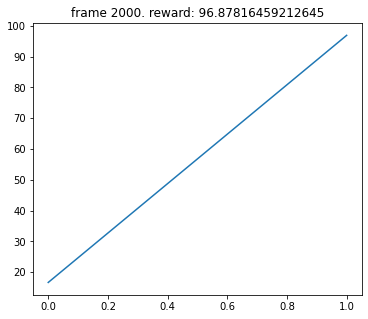

In [17]:
state = reset(envs)
early_stop = False

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        state = state.to(DEVICE)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = step(envs, action.cpu())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(reward.float().unsqueeze(1).to(DEVICE))
        masks.append((~done).float().unsqueeze(1).to(DEVICE))
        
        states.append(state)
        actions.append(action)
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_reward = np.mean([test_env(True) for _ in range(10)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards)
            if test_reward > threshold_reward: early_stop = True
            

    next_state = next_state.to(DEVICE)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)